In [ ]:
%%capture
!pip install psutil
!pip install GPUtil
!pip install matplotlib
!pip install torch
!pip install transformers
!pip install accelerate
!pip install safetensors
!pip install pytorch_memlab
!pip install huggingface_hub
!pip install -U memory_profiler
!pip install PyPDF2
!pip install reportlab
!pip install prettytable
!pip install fpdf
!pip install onnx
!pip install onnxruntime

In [ ]:
import onnx
import onnxruntime
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
import os
from tabulate import tabulate


class ModelProfiler:
    def __init__(self, models):
        self.models = models
        self.profile_data = pd.DataFrame(
            columns=["Model", "Layer", "CPU Time (ms)", "GPU Time (ms)"]
        )

    def convert_to_onnx(self, model_name):
        onnx_model_path = f"{model_name}.onnx"
        if not os.path.exists(onnx_model_path):
            model = AutoModel.from_pretrained(model_name)
            inputs = {
                "input_ids": torch.zeros([1, 512], dtype=torch.long),
                "attention_mask": torch.zeros([1, 512], dtype=torch.long),
            }
            torch.onnx.export(
                model,
                (inputs["input_ids"], inputs["attention_mask"]),
                onnx_model_path,
                input_names=["input_ids", "attention_mask"],
                output_names=["output"],
                opset_version=12,
            )
        return onnx_model_path



    def profile_model(self, model_name):
        # Load the tokenizer and onnx model
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        onnx_model_path = self.convert_to_onnx(model_name)
        onnx_model = onnx.load(onnx_model_path)

        # Create a dictionary of inputs
        inputs = {
            "input_ids": torch.randint(0, 100, (1, 512)).long(),
            "attention_mask": torch.ones(1, 512).long(),
        }

        # Load the onnx model
        session = onnxruntime.InferenceSession(onnx_model_path)
        input_names = [input.name for input in session.get_inputs()]
        output_names = [output.name for output in session.get_outputs()]

        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
              with record_function("model_inference"):
                  session.run(output_names, dict(zip(input_names, [inputs[name].numpy() for name in input_names])))

        # Analyze the profiling data
        self.profile_data = prof.key_averages().table(sort_by="self_cpu_memory_usage")
        print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))


        # Store the profiling data in the dataframe
        for layer in onnx_model.graph.node:
            layer_name = layer.name
            if layer.op_type == "Gemm":
                row = self.profile_data[self.profile_data["Name"] == layer_name]
                cpu_time = row["self_cpu_time_total"].values[0] / 1e6
                gpu_time = row["self_cuda_time_total"].values[0] / 1e6

                self.profile_data = self.profile_data.append(
                    {
                        "Model": model_name,
                        "Layer": layer_name,
                        "CPU Time (ms)": cpu_time,
                        "GPU Time (ms)": gpu_time,
                    },
                    ignore_index=True,
                )
        self.profile_data = self.profile_data.drop(columns=["Name", "Type", "Input Shapes", "Self CPU %", "CPU %", "CPU Time", "CUDA Time", "Calls"])
        self.profile_data = self.profile_data.sort_values(by=["GPU Time (ms)"], ascending=False)


    def run_profiling(self):
        for model_name in self.models:
            self.profile_model(model_name)

        # Calculate the mean and standard deviation of the CPU and GPU time for each layer and model
        agg_data = self.profile_data.groupby(["Model", "Layer"]).agg(
            {"CPU Time (ms)": ["mean", "std"], "GPU Time (ms)": ["mean", "std"]}
        )

        # Print the aggregated data
        print(agg_data)



    def visualize_profile_data(self, profile_data):
        # Group the data by model and layer and calculate the mean CPU and GPU time
        agg_data = self.profile_data.groupby(["Model", "Layer"]).agg({"CPU Time (ms)": "mean", "GPU Time (ms)": "mean"})

        # Create a horizontal bar chart for the mean CPU and GPU time
        agg_data.plot(kind="barh", figsize=(10, 8))
        plt.title("Mean CPU and GPU Time by Model and Layer")
        plt.xlabel("Time (ms)")
        plt.show()


    def display_profile_data(self, profile_data):
        # Group the data by model and layer and calculate the mean CPU and GPU time
        agg_data = self.profile_data.groupby(["Model", "Layer"]).agg({"CPU Time (ms)": "mean", "GPU Time (ms)": "mean"})

        # Convert the grouped data to a table using the tabulate package
        table = tabulate(agg_data, headers=["Model", "Layer", "Mean CPU Time (ms)", "Mean GPU Time (ms)"], tablefmt="pretty")

        # Print the table
        print(table)



In [ ]:
profiler = ModelProfiler(["bert-base-uncased", "distilbert-base-uncased"])
profiler.run_profiling()



In [ ]:
profiler.visualize_profile_data(profiler.profile_data)
profiler.display_profile_data(profiler.profile_data)

In [ ]:
import onnx
import onnxruntime
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
import os
from tabulate import tabulate


class ModelProfiler:
    def __init__(self, models):
        self.models = models
        self.profile_data = pd.DataFrame(
            columns=["Model", "Layer", "CPU Time (ms)", "GPU Time (ms)"]
        )

    def convert_to_onnx(self, model_name):
        onnx_model_path = f"{model_name}.onnx"
        if not os.path.exists(onnx_model_path):
            model = AutoModel.from_pretrained(model_name)
            inputs = {
                "input_ids": torch.zeros([1, 512], dtype=torch.long),
                "attention_mask": torch.zeros([1, 512], dtype=torch.long),
            }
            torch.onnx.export(
                model,
                (inputs["input_ids"], inputs["attention_mask"]),
                onnx_model_path,
                input_names=["input_ids", "attention_mask"],
                output_names=["output"],
                opset_version=12,
            )
        return onnx_model_path



    def profile_model(self, model_name):
        # Load the tokenizer and onnx model
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        onnx_model_path = self.convert_to_onnx(model_name)
        onnx_model = onnx.load(onnx_model_path)

        # Create a dictionary of inputs
        inputs = {
            "input_ids": torch.randint(0, 100, (1, 512)).long(),
            "attention_mask": torch.ones(1, 512).long(),
        }

        # Load the onnx model
        session = onnxruntime.InferenceSession(onnx_model_path)
        input_names = [input.name for input in session.get_inputs()]
        output_names = [output.name for output in session.get_outputs()]

        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
              with record_function("model_inference"):
                  session.run(output_names, dict(zip(input_names, [inputs[name].numpy() for name in input_names])))

        # Analyze the profiling data
        self.profile_data = prof.key_averages().table(sort_by="self_cpu_memory_usage")
        print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))


        # Store the profiling data in the dataframe
        for layer in onnx_model.graph.node:
            layer_name = layer.name
            if layer.op_type == "Gemm":
                row = self.profile_data[self.profile_data["Name"] == layer_name]
                cpu_time = row["self_cpu_time_total"].values[0] / 1e6
                gpu_time = row["self_cuda_time_total"].values[0] / 1e6

                self.profile_data = self.profile_data.append(
                    {
                        "Model": model_name,
                        "Layer": layer_name,
                        "CPU Time (ms)": cpu_time,
                        "GPU Time (ms)": gpu_time,
                    },
                    ignore_index=True,
                )
        self.profile_data = self.profile_data.drop(columns=["Name", "Type", "Input Shapes", "Self CPU %", "CPU %", "CPU Time", "CUDA Time", "Calls"])
        self.profile_data = self.profile_data.sort_values(by=["GPU Time (ms)"], ascending=False)


    def run_profiling(self):
        for model_name in self.models:
            self.profile_model(model_name)

        # Calculate the mean and standard deviation of the CPU and GPU time for each layer and model
        agg_data = self.profile_data.groupby(["Model", "Layer"]).agg(
            {"CPU Time (ms)": ["mean", "std"], "GPU Time (ms)": ["mean", "std"]}
        )

        # Print the aggregated data
        print(agg_data)



    def visualize_profile_data(self, profile_data):
        # Group the data by model and layer and calculate the mean CPU and GPU time
        agg_data = self.profile_data.groupby(["Model", "Layer"]).agg({"CPU Time (ms)": "mean", "GPU Time (ms)": "mean"})

        # Create a horizontal bar chart for the mean CPU and GPU time
        agg_data.plot(kind="barh", figsize=(10, 8))
        plt.title("Mean CPU and GPU Time by Model and Layer")
        plt.xlabel("Time (ms)")
        plt.show()


    def display_profile_data(self, profile_data):
        # Group the data by model and layer and calculate the mean CPU and GPU time
        agg_data = self.profile_data.groupby(["Model", "Layer"]).agg({"CPU Time (ms)": "mean", "GPU Time (ms)": "mean"})

        # Convert the grouped data to a table using the tabulate package
        table = tabulate(agg_data, headers=["Model", "Layer", "Mean CPU Time (ms)", "Mean GPU Time (ms)"], tablefmt="pretty")

        # Print the table
        print(table)



In [ ]:



class Profiler:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer, self.model, self.model_modules = self._load_model_without_weights(self.model_name)
        self.layer_names = [name for name, _ in self.model.named_parameters()]
        self.layer_times = np.zeros(len(self.layer_names))
        self.layer_cpu = np.zeros(len(self.layer_names))
        self.layer_cpu_percentage = np.zeros(len(self.layer_names))
        self.layer_gpu = np.zeros(len(self.layer_names))
        self.layer_gpu_percentage = np.zeros(len(self.layer_names))
        self.input_shape = None
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.profile_data = []
        


    def _load_model_without_weights(self, model_name):
        # Load the model configuration
        config = AutoConfig.from_pretrained(model_name, low_cpu_mem_usage=True)

        with init_empty_weights():
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            # Create an instance of the model without loading the weights
            model = AutoModel.from_config(config)

        device_map = infer_auto_device_map(model)
        model_modules = []
        # Print the layers and their properties
        for i, module in enumerate(model.modules()):
            #print(f"module {i}: {module}")
            model_modules.append(module)

        #model_modules = model.modules()

        return tokenizer, model, model_modules

    def model_size(self):
        model_size = sum(t.numel() for t in self.model.parameters())
        print(f"Model size: {model_size/1000**2:.1f}M parameters")
        return model_size

    def check_gpu(self):
        try:
            if torch.cuda.is_available():
                return True
            else:
                return False
        except ImportError:
            return False


    def convert_to_onnx(self, model_name):
        onnx_model_path = f"{model_name}.onnx"
        if not os.path.exists(onnx_model_path):
            model = AutoModel.from_pretrained(model_name)
            inputs = {
                "input_ids": torch.zeros([1, 512], dtype=torch.long),
                "attention_mask": torch.zeros([1, 512], dtype=torch.long),
            }
            torch.onnx.export(
                model,
                (inputs["input_ids"], inputs["attention_mask"]),
                onnx_model_path,
                input_names=["input_ids", "attention_mask"],
                output_names=["output"],
                opset_version=12,
            )
        return onnx_model_path



    def profile_model(self, model_name):
        # Load the tokenizer and onnx model
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        onnx_model_path = self.convert_to_onnx(model_name)
        onnx_model = onnx.load(onnx_model_path)

        # Create a dictionary of inputs
        inputs = {
            "input_ids": torch.randint(0, 100, (1, 512)).long(),
            "attention_mask": torch.ones(1, 512).long(),
        }

        # Load the onnx model
        session = onnxruntime.InferenceSession(onnx_model_path)
        input_names = [input.name for input in session.get_inputs()]
        output_names = [output.name for output in session.get_outputs()]

        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
              with record_function("model_inference"):
                  session.run(output_names, dict(zip(input_names, [inputs[name].numpy() for name in input_names])))

        # Analyze the profiling data
        #self.profile_data = prof.key_averages().table(sort_by="self_cpu_memory_usage")
        print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))






    def calculate_elapsed_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        #elapsed_time_ms = elapsed_time.total_seconds()
        return elapsed_time


    def get_cpu_memory_usage_mb(self):
        """Return CPU memory usage in MB."""
        process = psutil.Process()
        memory_info = process.memory_info()
        cpu_memory_usage = memory_info.rss / (1024 * 1024)
        return cpu_memory_usage

    def calculate_gpu_usage(self):
        if torch.cuda.is_available():
            # Get the current device
            device = torch.cuda.current_device()

            # Calculate the memory usage
            allocated =torch.cuda.max_memory_allocated() / (1024 * 1024)

        else:
            allocated = 0
        return allocated


    def perc_calculate_gpu_usage(self):
        if torch.cuda.is_available():
            # Get the current device
            device = torch.cuda.current_device()

            # Calculate the memory usage
            allocated = torch.cuda.memory_allocated(device)
            cached = torch.cuda.memory_reserved(device) - allocated
            utilization = allocated / (allocated + cached)

            # Calculate the GPU usage percentage
            gpu_usage_percentage = round(utilization * 100, 2)
        else:
            gpu_usage_percentage = 0.0

        return gpu_usage_percentage



    def calculate_gpu_usage_percentage(self):
        if torch.cuda.is_available():
            total_mem = torch.cuda.get_device_properties(0).total_memory
            allocated_mem = torch.cuda.memory_allocated()
            gpu_percentage = allocated_mem / total_mem * 100
            return gpu_percentage
        else:
            return 0


   

    def profile(self, input_tensor):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)
            
        with torch.autograd.profiler.profile(use_cuda=True) as prof:
          
        #with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,
              #        record_shapes=True) as prof:
          #with record_function("model_inference"):
        # Start the process
            output = self.model(input_tensor)
        print(prof)

        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory = True 
                     ,record_shapes=True,use_cuda=True,) as prof:
            with record_function("model_inference"):
                output = self.model(input_tensor)
        print(prof.key_averages(group_by_input_shape=True).table(sort_by="self_cpu_memory_usage"))




    def visualize_profile_results(self, layer_times, layer_cpu, layer_gpu):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.scatter(range(len(layer_times)), layer_times, s=2, label='Execution time')
        ax.scatter(range(len(layer_cpu)), layer_cpu, s=2, label='CPU memory')
        ax.scatter(range(len(layer_gpu)), layer_gpu, s=2, label='GPU memory')
        ax.set_xlabel('Layer index')
        ax.set_ylabel('Memory usage (MB) / Execution time (ms)')
        ax.set_title('Profiling Results')
        ax.legend()
        plt.show()

    
    def plot(self):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot timing information
        ax1.set_title("profiling_results - " + self.model_name)
        ax1.set_xlabel('Layer Index')
        ax1.set_ylabel('Time (ms)')
        ax1.plot(self.layer_times, 'b', label='Time')
        ax1.tick_params(axis='y', labelcolor='b')

        # Plot CPU and GPU memory usage information
        ax2 = ax1.twinx()
        ax2.set_ylabel('Memory Usage (MB)')
        ax2.plot(self.layer_cpu, 'g', label='CPU')
        ax2.plot(self.layer_gpu, 'r', label='GPU')
        ax2.tick_params(axis='y', labelcolor='g')

        # Add legend and display plot
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.grid()
        plt.show()

    def display_profiling_results(self):
        # Create a table to display the profiling results
        table = PrettyTable()
        table.field_names = ["Layer", "Total time (ms)", "CPU usage (MB)", "CPU usage (%)", "GPU usage (MB)", "GPU usage (%)"]
                           # ,"Memory usage (MB)", "CPU usage (MB)", "GPU usage (MB)" , "Disk usage (MB)"]
        for i, layer_name in enumerate(self.layer_names):
            table.add_row([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}" , f"{self.layer_cpu_percentage[i]:.2f}", f"{self.layer_gpu[i]:.2f}",  f"{self.layer_gpu_percentage[i]:.2f}"])
           # ,f"{self.mem[i]:.2f}", f"{self.cpu[i]:.2f}",f"{self.gpu[i]:.2f}",f"{self.disk[i]:.2f}"])

        # Print the table to the console
        print(table)


    def save_results_pdf(self):
        filename = "profiling_results - "+self.model_name+".pdf"
        # Create a list of lists to store the profiling results
        data = [["Layer", "Total time (ms)", "CPU usage (MB)", "CPU usage (%)", "GPU usage (MB)", "GPU usage (%)"]]
        for i, layer_name in enumerate(self.layer_names):
            data.append([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}", f"{self.layer_cpu_percentage[i]:.2f}", f"{self.layer_gpu[i]:.2f}",  f"{self.layer_gpu_percentage[i]:.2f}"])

        # Set up the reportlab PDF document
        doc = SimpleDocTemplate(filename, pagesize=landscape(letter))
        elements = []

        # Create the table and style
        table = Table(data, colWidths=[3.8*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch])
        table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.gray),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
            ("ALIGN", (0, 0), (-1, 0), "CENTER"),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica"),
            ("FONTSIZE", (0, 0), (-1, 0), 14),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 12),
            ("BACKGROUND", (0, 1), (-1, -1), colors.beige),
            ("TEXTCOLOR", (0, 1), (-1, -1), colors.black),
            ("ALIGN", (0, 1), (-1, -1), "CENTER"),
            ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
            ("FONTSIZE", (0, 1), (-1, -1), 12),
            ("BOTTOMPADDING", (0, 1), (-1, -1), 6),
            ("GRID", (0, 0), (-1, -1), 1, colors.black),
        ]))

        # Add the table to the elements list and write to the PDF
        elements.append(table)
        doc.build(elements)

        print(f"Results saved to {os.path.abspath(filename)}")


In [ ]:
#model_name = "bert-base-uncased"
#model_name = "optimum/gpt2"
#model_name = "bert-base-uncased"
#model_name = "xlm-roberta-large"
#model_name = "facebook/bart-large"
#model_name = "cerebras/Cerebras-GPT-13B"
#model_name = "facebook/opt-6.7b"
model_name = "facebook/mask2former-swin-large-cityscapes-semantic"

#model_name = "facebook/detr-resnet-101-dc5"


# Initialize the profiler
profiler = Profiler(model_name)

model= profiler.model
model_modules = profiler.model_modules
# Define your input tensor here
batch_size = 8
sequence_length = 128
input_tensor = torch.rand(batch_size, sequence_length).long()


# Run the profiler
profiler.profile(input_tensor)
#profiler.profile_model(input_tensor)
# Print the profiling results to the console and save to a PDF file
#filename = "profiling_results1.pdf"
#profiler.save_results_pdf()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 14>:14                                                                            │
│ in __init__:4                                                                                    │
│ in _load_model_without_weights:22                                                                │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/transformers/models/auto/tokenization_auto.py:695 in      │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   692 │   │                                                                                      │
│   693 │   │   model_type = config_class_to_model_type(type(config).__name__)                     │
│   694 │   │   if model_type is not None:                                                         │
│ ❱ 695 │   │   │   tokenizer_class_py, tokenizer_class_fast = TOKENIZER_MAPPING[type(config)]     │
│   696 │   │   │   if tokenizer_class_fast and (use_fast or tokenizer_class_py is None):          │
│   697 │   │   │   │   return tokenizer_class_fast.from_pretrained(pretrained_model_name_or_pat   │
│   698 │   │   │   else:                                                                          │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/transformers/models/auto/auto_factory.py:610 in           │
│ __getitem__                                                                                      │
│                                                                                                  │
│   607 │   │   │   if mtype in self._model_mapping:                                               │
│   608 │   │   │   │   model_name = self._model_mapping[mtype]                                    │
│   609 │   │   │   │   return self._load_attr_from_module(mtype, model_name)                      │
│ ❱ 610 │   │   raise KeyError(key)                                                                │
│   611 │                                                                                          │
│   612 │   def _load_attr_from_module(self, model_type, attr):                                    │
│   613 │   │   module_name = model_type_to_module_name(model_type)                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: <class 'transformers.models.mask2former.configuration_mask2former.Mask2FormerConfig'>

In [ ]:

        # Store the profiling data in the dataframe
        for layer in onnx_model.graph.node:
            layer_name = layer.name
            if layer.op_type == "Gemm":
                row = self.profile_data[self.profile_data["Name"] == layer_name]
                cpu_time = row["self_cpu_time_total"].values[0] / 1e6
                gpu_time = row["self_cuda_time_total"].values[0] / 1e6

                self.profile_data = self.profile_data.append(
                    {
                        "Model": model_name,
                        "Layer": layer_name,
                        "CPU Time (ms)": cpu_time,
                        "GPU Time (ms)": gpu_time,
                    },
                    ignore_index=True,
                )

## **load_model_without_weights**

In [ ]:
model_name = "bert-base-uncased"
#model_name = "cerebras/Cerebras-GPT-13B"
#model_name = "facebook/opt-6.7b"

def load_model_without_weights(model_name):
    # Load the model configuration
    config = AutoConfig.from_pretrained(model_name, low_cpu_mem_usage=True)

    with init_empty_weights():

      tokenizer = AutoTokenizer.from_pretrained(model_name)
      # Create an instance of the model without loading the weights
      model = AutoModel.from_config(config)
      #model = AutoModelForCausalLM.from_config(config)
      #model = AutoModelForSeq2SeqLM.from_config(config)
    
    device_map = infer_auto_device_map(model)

    # Print the layers and their properties
    for i, module in enumerate(model.modules()):
        print(f"module {i}: {module}")

    return tokenizer, model

In [ ]:
import psutil
import os

class MemoryMonitor:
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.memory_history = []
    
    def memory_usage_mb(self):
        """Return the memory usage of the current process in MB."""
        mem = self.process.memory_info().rss / 1024 / 1024
        return mem
    
    def cpu_usage(self):
        """Return the CPU usage percentage of the current process."""
        return self.process.cpu_percent()
    
    def gpu_memory_usage(self, device=0):
        """Return the GPU memory usage in MB for a given device (default 0)."""
        import torch
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats(device)
            return torch.cuda.max_memory_allocated(device) / 1024 / 1024
        else:
            return 0
    
    def disk_usage_mb(self):
        """Return the disk usage in MB of the current working directory."""
        total, used, free = shutil.disk_usage(".")
        return used / 1024 / 1024
    
    def monitor(self):
        """Record the memory usage and CPU usage of the current process."""
        mem = self.memory_usage_mb()
        cpu = self.cpu_usage()
        gpu = self.gpu_memory_usage()
        disk = self.disk_usage_mb()
        self.memory_history.append((mem, cpu, gpu, disk))
        return mem, cpu, gpu, disk


In [ ]:
###################################################### OK

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import torch
import os
import time
from io import BytesIO
from reportlab.pdfgen import canvas
from PyPDF2 import PdfMerger
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from prettytable import PrettyTable
from fpdf import FPDF
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
import psutil
import shutil
import transformers
from transformers import AutoConfig, AutoModel
import accelerate
from accelerate import infer_auto_device_map, init_empty_weights
from transformers import AutoConfig, AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:

#nice

class Profiler:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer, self.model, self.model_modules = self._load_model_without_weights(self.model_name)
        self.layer_names = [name for name, _ in self.model.named_parameters()]
        self.layer_times = np.zeros(len(self.layer_names))
        self.layer_cpu = np.zeros(len(self.layer_names))
        self.layer_cpu_percentage = np.zeros(len(self.layer_names))
        self.layer_gpu = np.zeros(len(self.layer_names))
        self.layer_gpu_percentage = np.zeros(len(self.layer_names))
        self.input_shape = None
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        


    def _load_model_without_weights(self, model_name):
        # Load the model configuration
        config = AutoConfig.from_pretrained(model_name, low_cpu_mem_usage=True)

        with init_empty_weights():
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            # Create an instance of the model without loading the weights
            model = AutoModel.from_config(config)

        device_map = infer_auto_device_map(model)
        model_modules = []
        # Print the layers and their properties
        for i, module in enumerate(model.modules()):
            #print(f"module {i}: {module}")
            model_modules.append(module)

        #model_modules = model.modules()

        return tokenizer, model, model_modules

    def model_size(self):
        model_size = sum(t.numel() for t in self.model.parameters())
        print(f"Model size: {model_size/1000**2:.1f}M parameters")
        return model_size

    def check_gpu(self):
        try:
            if torch.cuda.is_available():
                return True
            else:
                return False
        except ImportError:
            return False

    def calculate_elapsed_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        #elapsed_time_ms = elapsed_time.total_seconds()
        return elapsed_time


    def get_cpu_memory_usage_mb(self):
        """Return CPU memory usage in MB."""
        process = psutil.Process()
        memory_info = process.memory_info()
        cpu_memory_usage = memory_info.rss / (1024 * 1024)
        return cpu_memory_usage

    def calculate_gpu_usage(self):
        if torch.cuda.is_available():
            # Get the current device
            device = torch.cuda.current_device()

            # Calculate the memory usage
            allocated =torch.cuda.max_memory_allocated() / (1024 * 1024)

        else:
            allocated = 0
        return allocated


    def perc_calculate_gpu_usage(self):
        if torch.cuda.is_available():
            # Get the current device
            device = torch.cuda.current_device()

            # Calculate the memory usage
            allocated = torch.cuda.memory_allocated(device)
            cached = torch.cuda.memory_reserved(device) - allocated
            utilization = allocated / (allocated + cached)

            # Calculate the GPU usage percentage
            gpu_usage_percentage = round(utilization * 100, 2)
        else:
            gpu_usage_percentage = 0.0

        return gpu_usage_percentage



    def calculate_gpu_usage_percentage(self):
        if torch.cuda.is_available():
            total_mem = torch.cuda.get_device_properties(0).total_memory
            allocated_mem = torch.cuda.memory_allocated()
            gpu_percentage = allocated_mem / total_mem * 100
            return gpu_percentage
        else:
            return 0


   

    def profile(self, input_tensor):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)
            
        with torch.autograd.profiler.profile(use_cuda=True) as prof:
          
        #with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,
              #        record_shapes=True) as prof:
          #with record_function("model_inference"):
        # Start the process
            output = self.model(input_tensor)
        print(prof)

        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory = True 
                     ,record_shapes=True,use_cuda=True,) as prof:
            with record_function("model_inference"):
                output = self.model(input_tensor)
        print(prof.key_averages(group_by_input_shape=True).table(sort_by="self_cpu_memory_usage"))

        
        # Loop through each layer and record timing information
        for i, (name, param) in enumerate(self.model.named_parameters()):
            if param.requires_grad:
                layer = name.split('.')[0]
                
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
                start_time.record()
                #with torch.autograd.profiler.profile(use_cuda=True) as prof:
                #with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,
                     #        record_shapes=True) as prof:
                  #with record_function("model_inference"):
                # Start the process
                output = self.model(input_tensor)
                #print(prof)
                #print(prof.key_averages().table(sort_by="self_cuda_time_total"))
                end_time.record()
                torch.cuda.synchronize()
                elapsed_time = start_time.elapsed_time(end_time)
                self.layer_times[i] = elapsed_time
                """
                start_time = time.time()
                #with torch.autograd.profiler.profile(enabled=True, use_cuda=self.check_gpu()) as prof:
                output = self.model(input_tensor)
                end_time = time.time()
                """
                #elapsed_time = self.calculate_elapsed_time(start_time, end_time)

                self.layer_cpu[i] = self.get_cpu_memory_usage_mb()
                self.layer_cpu_percentage[i] = elapsed_time / 1000 # convert to ms
                
                if torch.cuda.is_available():
                    #self.layer_gpu[i] = torch.cuda.max_memory_allocated() / (1024 * 1024)
                    self.layer_gpu[i] = self.calculate_gpu_usage() 
                    self.layer_gpu_percentage[i]=self.calculate_gpu_usage_percentage()
                else:
                    self.layer_gpu[i]=0
                    self.layer_gpu_percentage[i]=0 



                    """
                    if torch.cuda.max_memory_reserved() == 0:
                        self.layer_gpu_percentage[i] = 0
                    else:
                        gpu_percentage = torch.cuda.max_memory_allocated() / torch.cuda.max_memory_reserved() * 100
                        self.layer_gpu_percentage[i] = self.layer_gpu[i] / gpu_percentage
                else:
                    self.layer_gpu[i]=0
                    self.layer_gpu_percentage[i]=0
                  """
                

    def visualize_profile_results(self, layer_times, layer_cpu, layer_gpu):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.scatter(range(len(layer_times)), layer_times, s=2, label='Execution time')
        ax.scatter(range(len(layer_cpu)), layer_cpu, s=2, label='CPU memory')
        ax.scatter(range(len(layer_gpu)), layer_gpu, s=2, label='GPU memory')
        ax.set_xlabel('Layer index')
        ax.set_ylabel('Memory usage (MB) / Execution time (ms)')
        ax.set_title('Profiling Results')
        ax.legend()
        plt.show()

    
    def plot(self):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot timing information
        ax1.set_title("profiling_results - " + self.model_name)
        ax1.set_xlabel('Layer Index')
        ax1.set_ylabel('Time (ms)')
        ax1.plot(self.layer_times, 'b', label='Time')
        ax1.tick_params(axis='y', labelcolor='b')

        # Plot CPU and GPU memory usage information
        ax2 = ax1.twinx()
        ax2.set_ylabel('Memory Usage (MB)')
        ax2.plot(self.layer_cpu, 'g', label='CPU')
        ax2.plot(self.layer_gpu, 'r', label='GPU')
        ax2.tick_params(axis='y', labelcolor='g')

        # Add legend and display plot
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.grid()
        plt.show()

    def display_profiling_results(self):
        # Create a table to display the profiling results
        table = PrettyTable()
        table.field_names = ["Layer", "Total time (ms)", "CPU usage (MB)", "CPU usage (%)", "GPU usage (MB)", "GPU usage (%)"]
                           # ,"Memory usage (MB)", "CPU usage (MB)", "GPU usage (MB)" , "Disk usage (MB)"]
        for i, layer_name in enumerate(self.layer_names):
            table.add_row([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}" , f"{self.layer_cpu_percentage[i]:.2f}", f"{self.layer_gpu[i]:.2f}",  f"{self.layer_gpu_percentage[i]:.2f}"])
           # ,f"{self.mem[i]:.2f}", f"{self.cpu[i]:.2f}",f"{self.gpu[i]:.2f}",f"{self.disk[i]:.2f}"])

        # Print the table to the console
        print(table)


    def save_results_pdf(self):
        filename = "profiling_results - "+self.model_name+".pdf"
        # Create a list of lists to store the profiling results
        data = [["Layer", "Total time (ms)", "CPU usage (MB)", "CPU usage (%)", "GPU usage (MB)", "GPU usage (%)"]]
        for i, layer_name in enumerate(self.layer_names):
            data.append([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}", f"{self.layer_cpu_percentage[i]:.2f}", f"{self.layer_gpu[i]:.2f}",  f"{self.layer_gpu_percentage[i]:.2f}"])

        # Set up the reportlab PDF document
        doc = SimpleDocTemplate(filename, pagesize=landscape(letter))
        elements = []

        # Create the table and style
        table = Table(data, colWidths=[3.8*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch])
        table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.gray),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
            ("ALIGN", (0, 0), (-1, 0), "CENTER"),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica"),
            ("FONTSIZE", (0, 0), (-1, 0), 14),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 12),
            ("BACKGROUND", (0, 1), (-1, -1), colors.beige),
            ("TEXTCOLOR", (0, 1), (-1, -1), colors.black),
            ("ALIGN", (0, 1), (-1, -1), "CENTER"),
            ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
            ("FONTSIZE", (0, 1), (-1, -1), 12),
            ("BOTTOMPADDING", (0, 1), (-1, -1), 6),
            ("GRID", (0, 0), (-1, -1), 1, colors.black),
        ]))

        # Add the table to the elements list and write to the PDF
        elements.append(table)
        doc.build(elements)

        print(f"Results saved to {os.path.abspath(filename)}")


In [ ]:
#model_name = "bert-base-uncased"
#model_name = "optimum/gpt2"
#model_name = "bert-base-uncased"
#model_name = "xlm-roberta-large"
#model_name = "facebook/bart-large"
#model_name = "cerebras/Cerebras-GPT-13B"
model_name = "facebook/opt-6.7b"

# Initialize the profiler
profiler = Profiler(model_name)

model= profiler.model
model_modules = profiler.model_modules
# Define your input tensor here
batch_size = 8
sequence_length = 128
input_tensor = torch.rand(batch_size, sequence_length).long()


# Run the profiler
profiler.profile(input_tensor)

# Print the profiling results to the console and save to a PDF file
#filename = "profiling_results1.pdf"
#profiler.save_results_pdf()

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                   aten::view         0.00%      10.000us         0.00%      10.000us      10.000us      20.000us         0.00%      20.000us      20.000us             1  
              aten::embedding         0.01%      56.000us         0.04%     253.000us     253.000us      57.000us         0.01%     260.000us     260.000us             1  
                  aten::index         0.02%      94.000us         0.03%     197.000us     197.000us      94.000us         0.02%     203.000

In [ ]:
profiler.display_profiling_results()

+-----------------------------------------------+-----------------+----------------+---------------+----------------+---------------+
|                     Layer                     | Total time (ms) | CPU usage (MB) | CPU usage (%) | GPU usage (MB) | GPU usage (%) |
+-----------------------------------------------+-----------------+----------------+---------------+----------------+---------------+
|          decoder.embed_tokens.weight          |      405.67     |    4300.86     |      0.41     |      0.00      |      0.00     |
|         decoder.embed_positions.weight        |      388.57     |    4300.86     |      0.39     |      0.00      |      0.00     |
|        decoder.final_layer_norm.weight        |      383.59     |    4300.86     |      0.38     |      0.00      |      0.00     |
|         decoder.final_layer_norm.bias         |      347.73     |    4300.86     |      0.35     |      0.00      |      0.00     |
|    decoder.layers.0.self_attn.k_proj.weight   |      233.47 

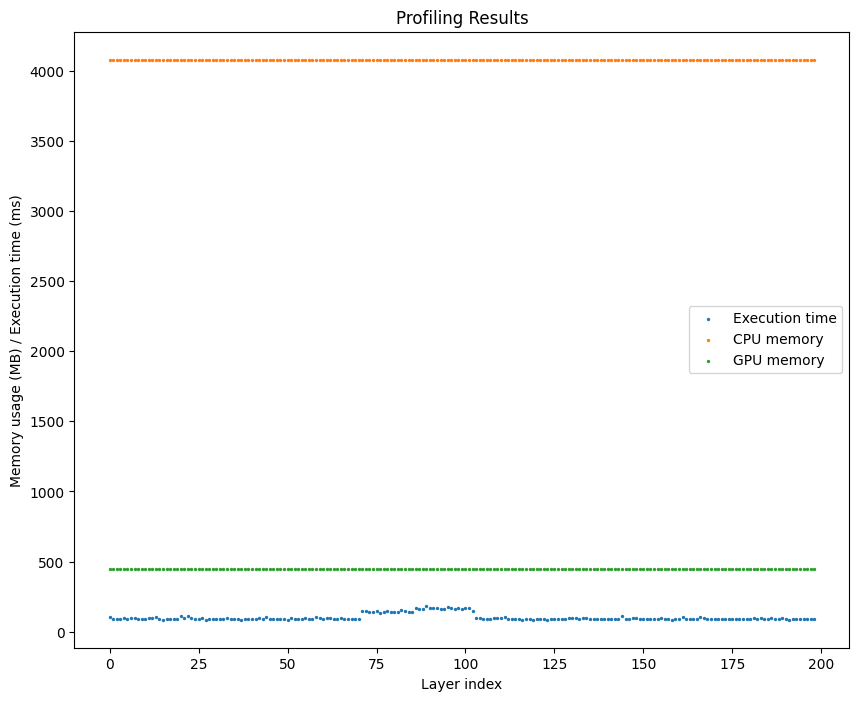

In [ ]:
profiler.visualize_profile_results(profiler.layer_times, profiler.layer_cpu, profiler.layer_gpu)


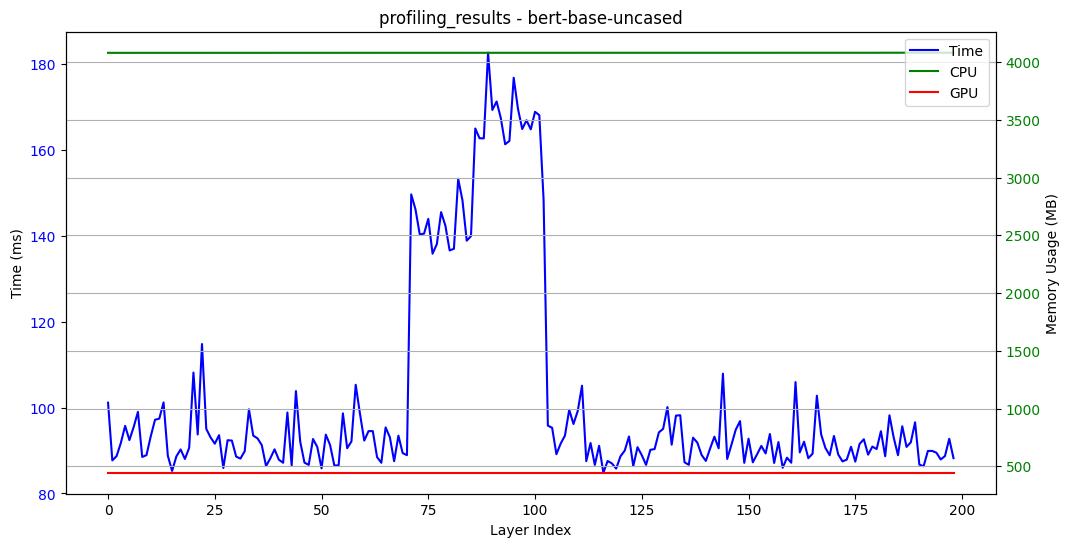

In [ ]:
profiler.plot()

In [ ]:
profiler.save_results_pdf()

Results saved to /content/profiling_resultsbert-base-uncased.pdf


In [ ]:
profiler.model_size()

Model size: 109.5M parameters


109482240

In [ ]:
### nice

import torch
import time
import psutil
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM


class ModelProfiler:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.input_shape = None
        self.cpu_memory_usage = []
        self.gpu_memory_usage = []
        self.latency = []

    def get_cpu_memory_usage_mb(self):
        process = psutil.Process()
        memory_info = process.memory_info()
        cpu_memory_usage = memory_info.rss / (1024 * 1024)
        return cpu_memory_usage

    def benchmark(self, num_runs, sequence_length):
        self.input_shape = (1, sequence_length)
        inputs = self.tokenizer.encode_plus(
            "Hello, my name is GPT. I am a large language model.",
            add_special_tokens=True,
            padding="max_length",
            max_length=sequence_length,
            return_tensors="pt",
        )

        # Move input tensor to the same device as the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        input_tensor = inputs["input_ids"].to(device)

        # Move the model to the same device as the input tensor
        self.model = self.model.to(device)

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)

        for i in range(num_runs):
            # Start the timer
            start_time = time.time()

            # Run the model forward pass
            with torch.no_grad():
                self.model(input_tensor)

            # Record the latency
            end_time = time.time()
            latency = end_time - start_time
            self.latency.append(latency)

            # Record CPU and GPU memory usage
            cpu_memory_usage = self.get_cpu_memory_usage_mb()
            self.cpu_memory_usage.append(cpu_memory_usage)

            if torch.cuda.is_available():
                gpu_memory_usage = torch.cuda.max_memory_allocated() / (1024 * 1024)
                self.gpu_memory_usage.append(gpu_memory_usage)

    def print_summary(self):
        print(f"Model: {self.model_name}")
        print(f"Input shape: {self.input_shape}")
        print(f"Number of runs: {len(self.latency)}")
        print(f"Average latency: {np.mean(self.latency):.4f} s")
        print(f"Standard deviation of latency: {np.std(self.latency):.4f} s")
        print(f"Average CPU memory usage: {np.mean(self.cpu_memory_usage):.4f} MB")
        print(f"Average GPU memory usage: {np.mean(self.gpu_memory_usage):.4f} MB")




In [ ]:
# Example usage
model_name = "bert-base-uncased"
profiler = ModelProfiler(model_name)
profiler.benchmark(num_runs=10, sequence_length=128)
profiler.print_summary()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model: bert-base-uncased
Input shape: (1, 128)
Number of runs: 10
Average latency: 0.0117 s
Standard deviation of latency: 0.0035 s
Average CPU memory usage: 4137.8672 MB
Average GPU memory usage: 443.6357 MB


In [ ]:
import torch
import time
import psutil
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM


class ModelProfiler:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.input_shape = None
        self.cpu_memory_usage = []
        self.gpu_memory_usage = []
        self.latency = []
        self.layer_latencies = []

    def get_cpu_memory_usage_mb(self):
        process = psutil.Process()
        memory_info = process.memory_info()
        cpu_memory_usage = memory_info.rss / (1024 * 1024)
        return cpu_memory_usage

    def benchmark(self, num_runs, sequence_length):
        self.input_shape = (1, sequence_length)
        inputs = self.tokenizer.encode_plus(
            "Hello, my name is ChatGPT. I am a large language model.",
            add_special_tokens=True,
            padding="max_length",
            max_length=sequence_length,
            return_tensors="pt",
        )

        # Move input tensor to the same device as the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        input_tensor = inputs["input_ids"].to(device)

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)

        # Get a list of all the layers in the model
        layers = self.model.named_modules()
        layers = [(name, layer) for name, layer in layers if isinstance(layer, torch.nn.Module)]

        for i in range(num_runs):
            layer_latencies = []

            for name, layer in layers:
                # Start the timer
                start_time = time.time()

                # Run the model forward pass through the current layer
                with torch.no_grad():
                    input_tensor = layer(input_tensor)

                # Record the latency
                end_time = time.time()
                latency = end_time - start_time
                layer_latencies.append(latency)

                # Record CPU and GPU memory usage
                cpu_memory_usage = self.get_cpu_memory_usage_mb()
                self.cpu_memory_usage.append(cpu_memory_usage)

                if torch.cuda.is_available():
                    gpu_memory_usage = torch.cuda.max_memory_allocated() / (1024 * 1024)
                    self.gpu_memory_usage.append(gpu_memory_usage)

            self.layer_latencies.append(layer_latencies)

        # Get the average latency for each layer over all the runs
        avg_layer_latencies = np.mean(self.layer_latencies, axis=0)
        self.layer_latencies = avg_layer_latencies.tolist()

    def print_summary(self):
        print(f"Model: {self.model_name}")
        print(f"Input shape: {self.input_shape}")
        print(f"Number of runs: {len(self.layer_latencies)}")
        for i, latency in enumerate(self.layer_latencies):
            print(f"Layer {i+1} - Average latency: {latency:.4f} s")
        print(f"Average CPU memory usage: {np.mean(self.cpu_memory_usage):.4f} MB")
        print(f"Average GPU memory usage: {np.mean(self.gpu_memory_usage):.4f} MB")


In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForMaskedLM
#from model_profiler import ModelProfiler

# Define a list of pre-trained models to test
models = [
    "bert-base-uncased",
    "bert-large-uncased",
    "gpt2",
    "gpt2-medium",
    "gpt2-large",
    "distilgpt2",
    "roberta-base",
    "roberta-large",
    "albert-base-v2",
    "albert-large-v2"
]

# Define the sequence length to test
sequence_length = 128

# Run the benchmarks for each model
for model_name in models:
    profiler = ModelProfiler(model_name)
    profiler.benchmark(num_runs=10, sequence_length=sequence_length)
    profiler.print_summary()
    print("")
    time.sleep(2)


In [ ]:
############ OK
import torch
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import torch
import os

from io import BytesIO
from reportlab.pdfgen import canvas
from PyPDF2 import PdfMerger
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from prettytable import PrettyTable
from fpdf import FPDF
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
import psutil
import shutil


class LayerProfiler:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer, self.model = self._load_model_without_weights(self.model_name)
        self.layer_names = [name for name, _ in self.model.named_parameters()]
        self.layer_times = np.zeros(len(self.layer_names))
        self.layer_cpu = np.zeros(len(self.layer_names))
        self.layer_gpu = np.zeros(len(self.layer_names))
        self.input_shape = None
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.process = psutil.Process(os.getpid())
        self.mem = np.zeros(len(self.layer_names))
        self.cpu = np.zeros(len(self.layer_names))
        self.gpu = np.zeros(len(self.layer_names))
        self.disk = np.zeros(len(self.layer_names))
        self.memory_history = []
 


    def _load_model_without_weights(self, model_name):
        # Load the model configuration
        config = AutoConfig.from_pretrained(model_name, low_cpu_mem_usage=True)

        with init_empty_weights():
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            # Create an instance of the model without loading the weights
            model = AutoModel.from_config(config)

        device_map = infer_auto_device_map(model)

        # Print the layers and their properties
        for i, module in enumerate(model.modules()):
            print(f"module {i}: {module}")

        return tokenizer, model

    def model_size(self, model):
        model_size = sum(t.numel() for t in self.model.parameters())
        print(f"Model size: {model_size/1000**2:.1f}M parameters")


    def memory_usage_mb(self):
        """Return the memory usage of the current process in MB."""
        mem = self.process.memory_info().rss / 1024 / 1024
        return mem
    
    def cpu_usage(self):
        """Return the CPU usage percentage of the current process."""
        return self.process.cpu_percent()
    
    def gpu_memory_usage(self, device=0):
        """Return the GPU memory usage in MB for a given device (default 0)."""
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats(device)
            return torch.cuda.max_memory_allocated(device) / 1024 / 1024
        else:
            return 0
    
    def disk_usage_mb(self):
        """Return the disk usage in MB of the current working directory."""
        total, used, free = shutil.disk_usage(".")
        return used / 1024 / 1024
    
    def monitor(self):
        """Record the memory usage and CPU usage of the current process."""
        mem = self.memory_usage_mb()
        cpu = self.cpu_usage()
        gpu = self.gpu_memory_usage()
        disk = self.disk_usage_mb()
        self.memory_history.append((mem, cpu, gpu, disk))
        return mem, cpu, gpu, disk


    def profile(self, input_tensor):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        #device = self.device
        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)

        # Loop through each layer and record timing information
        for i, (name, param) in enumerate(self.model.named_parameters()):
            if param.requires_grad:
                layer = name.split('.')[0]
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
                start_time.record()
                output = self.model(input_tensor)
                end_time.record()
                torch.cuda.synchronize()
                elapsed_time = start_time.elapsed_time(end_time)
                self.layer_times[i] = elapsed_time
                self.layer_cpu[i] = elapsed_time / 1000 # convert to ms


                
                
                if torch.cuda.is_available():
                    self.layer_gpu[i] = torch.cuda.max_memory_allocated() / 1024 / 1024
                    if torch.cuda.max_memory_reserved() == 0:
                        gpu_percentage = 0
                    else:
                        gpu_percentage = torch.cuda.max_memory_allocated() / torch.cuda.max_memory_reserved() * 100
                    self.layer_gpu[i] /= gpu_percentage

                #self.mem[i] = self.memory_usage_mb()
                #self.cpu[i] = self.cpu_usage()
                #self.gpu[i] = self.gpu_memory_usage()
                #self.disk[i] = self.disk_usage_mb()

                #self.memory_history[i] = self.monitor()
                self.mem[i],self.cpu[i], self.gpu[i], self.disk[i] = self.monitor()
                
                #print(self.memory_history[i])
                #print(mem,cpu, gpu, disk)


                
                
                  

                

    def plot(self):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot timing information
        ax1.set_title('Layer Profiling Results')
        ax1.set_xlabel('Layer Index')
        ax1.set_ylabel('Time (ms)')
        ax1.plot(self.layer_times, 'b', label='Time')
        ax1.tick_params(axis='y', labelcolor='b')

        # Plot CPU and GPU memory usage information
        ax2 = ax1.twinx()
        ax2.set_ylabel('Memory Usage (%)')
        ax2.plot(self.layer_cpu, 'g', label='CPU')
        ax2.plot(self.layer_gpu, 'r', label='GPU')
        ax2.tick_params(axis='y', labelcolor='g')

        # Add legend and display plot
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.grid()
        plt.show()


    def display_profiling_results(self):
        # Create a table to display the profiling results
        table = PrettyTable()
        table.field_names = ["Layer", "Total time (ms)", "CPU usage (%)", "GPU usage (%)"
                            ,"Memory usage (MB)", "CPU usage (MB)", "GPU usage (MB)" , "Disk usage (MB)"]
        for i, layer_name in enumerate(self.layer_names):
            table.add_row([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}", f"{self.layer_gpu[i]:.2f}"
            ,f"{self.mem[i]:.2f}", f"{self.cpu[i]:.2f}",f"{self.gpu[i]:.2f}",f"{self.disk[i]:.2f}"])

        # Print the table to the console
        print(table)


    def save_results_pdf(self, filename):
        # Create a list of lists to store the profiling results
        data = [["Layer", "Total time (ms)", "CPU usage (%)", "GPU usage (%)"]]
        for i, layer_name in enumerate(self.layer_names):
            data.append([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}", f"{self.layer_gpu[i]:.2f}"])

        # Set up the reportlab PDF document
        doc = SimpleDocTemplate(filename, pagesize=landscape(letter))
        elements = []

        # Create the table and style
        table = Table(data, colWidths=[5*inch, 1.5*inch, 1.5*inch, 1.5*inch])
        table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.gray),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
            ("ALIGN", (0, 0), (-1, 0), "CENTER"),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
            ("FONTSIZE", (0, 0), (-1, 0), 14),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 12),
            ("BACKGROUND", (0, 1), (-1, -1), colors.beige),
            ("TEXTCOLOR", (0, 1), (-1, -1), colors.black),
            ("ALIGN", (0, 1), (-1, -1), "CENTER"),
            ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
            ("FONTSIZE", (0, 1), (-1, -1), 12),
            ("BOTTOMPADDING", (0, 1), (-1, -1), 6),
            ("GRID", (0, 0), (-1, -1), 1, colors.black),
        ]))

        # Add the table to the elements list and write to the PDF
        elements.append(table)
        doc.build(elements)

        print(f"Results saved to {os.path.abspath(filename)}")



In [ ]:
from prettytable import PrettyTable

# Create a table to display the profiling results
table = PrettyTable()
table.field_names = ["Layer", "Total time (ms)", "CPU usage (%)", "GPU usage (%)"]
for i, layer_name in enumerate(profiler.layer_names):
    table.add_row([layer_name, f"{profiler.layer_times[i]:.2f}", f"{profiler.layer_cpu[i]:.2f}", f"{profiler.layer_gpu[i]:.2f}"])

# Print the table to the console
print(table)


In [ ]:
import psutil

# Get the process ID of the current Python process
pid = psutil.Process()

# Get the memory usage of the current Python process in MB
memory_usage_mb = pid.memory_info().rss / 1024 / 1024

print(f"Memory usage: {memory_usage_mb:.2f} MB")


test

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
from accelerate import init_empty_weights, infer_auto_device_map
from torch.profiler import profile, ProfilerActivity
from prettytable import PrettyTable
import torch
import os


class ModelProfiler:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer, self.model = self._load_model_without_weights(model_name)

    def _load_model_without_weights(self, model_name):
        # Load the model configuration
        config = AutoConfig.from_pretrained(model_name, low_cpu_mem_usage=True)

        with init_empty_weights():
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            # Create an instance of the model without loading the weights
            model = AutoModel.from_config(config)

        device_map = infer_auto_device_map(model)

        # Print the layers and their properties
        for i, module in enumerate(model.modules()):
            print(f"module {i}: {module}")

        return tokenizer, model

    def cpu_memory_usage(self, input_ids, attention_mask=None):
        with torch.no_grad():
            inputs = {"input_ids": input_ids}
            if attention_mask is not None:
                inputs["attention_mask"] = attention_mask

            # Forward pass through the model
            with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
                self.model.eval()
                self.model(**inputs)

            # Get the total CPU memory usage in bytes
            total_cpu_memory = prof.total_cpu_mem / 1024 / 1024

            return total_cpu_memory

    def gpu_memory_usage(self, input_ids, attention_mask=None):
        if torch.cuda.is_available():
            with torch.no_grad():
                inputs = {"input_ids": input_ids.cuda()}
                if attention_mask is not None:
                    inputs["attention_mask"] = attention_mask.cuda()

                # Forward pass through the model
                with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
                    self.model.cuda()
                    self.model(**inputs)

                # Get the total GPU memory usage in bytes
                total_gpu_memory = prof.total_cuda_mem / 1024 / 1024

                return total_gpu_memory
        else:
            print("No CUDA device available.")
            return None

    def plot(self):
        """
        Plots the time spent by each layer during inference and the GPU and CPU memory usage of each layer.
        """
        # Create subplots for the layer times and memory usage
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        
        # Plot the layer times
        ax1.barh(self.layer_names, self.layer_times)
        ax1.set_title("Layer Inference Time (ms)")
        ax1.set_xlabel("Time (ms)")
        
        # Plot the memory usage
        ind = np.arange(len(self.layer_names))
        width = 0.35
        p1 = ax2.barh(ind, self.layer_cpu_mem, width)
        p2 = ax2.barh(ind, self.layer_gpu_mem, width, left=self.layer_cpu_mem)
        ax2.set_title("Layer Memory Usage (MB)")
        ax2.set_xlabel("Memory (MB)")
        ax2.set_yticks(ind)
        ax2.set_yticklabels(self.layer_names)
        ax2.legend((p1[0], p2[0]), ("CPU", "GPU"))
        
        # Display the plot
        plt.show()


    def save_results_pdf(self, filename):
        # Create a table to display the profiling results
        table = PrettyTable()
        table.field_names = ["Layer", "Total time (ms)", "CPU usage (MB)", "GPU usage (MB)"]
        for i, layer_name in enumerate(self.profiler.layer_names):
            table.add_row([layer_name, f"{self.profiler.layer_times[i]:.2f}", f"{self.profiler.layer_cpu[i]:.2f}", f"{self.profiler.layer_gpu[i]:.2f}"])

        # Print the table to the console
        print(table)

        # Save the table to a PDF file
        with open(filename, "w") as f:
            f.write(table.get_string())

        print(f"Results saved to {os.path.abspath(filename)}")


In [ ]:
from transformers import BertModel, BertTokenizer, AutoConfig, AutoTokenizer
import torch

# Initialize BERT model and tokenizer
#model = BertModel.from_pretrained('bert-base-uncased')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_name = 'bert-base-uncased'
# Define input
text = "Hello, how are you today?"

# Create instance of LayerProfiler and profile the model
profiler = LayerProfiler(model_name)
model= profiler.model
tokenizer = profiler.tokenizer
#device = profiler.device
inputs = tokenizer(text, return_tensors='pt').to(device)

profiler.profile(inputs['input_ids'])




module 0: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace

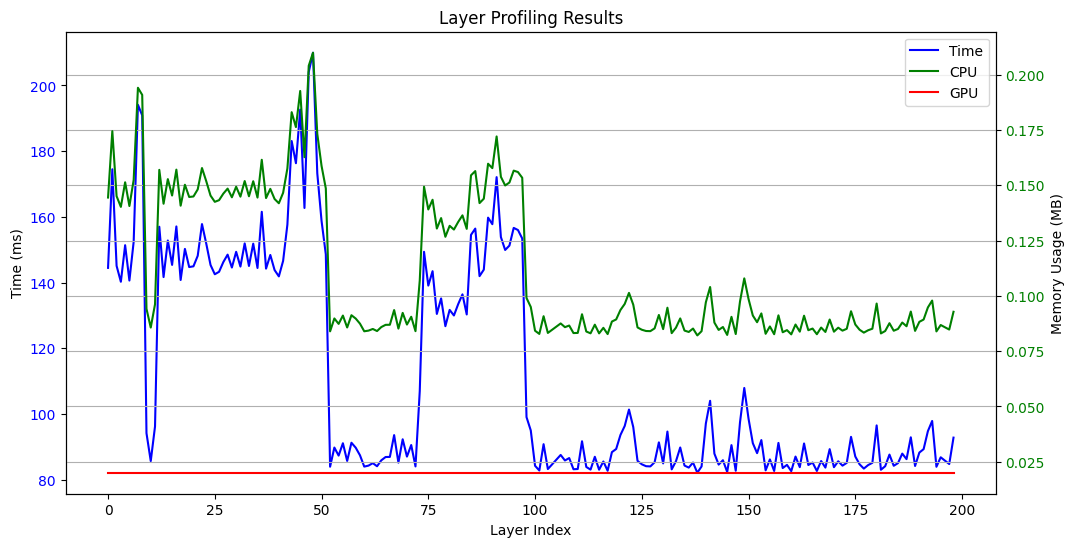

In [ ]:
# Visualize profiling results
profiler.plot()

In [ ]:
profiler.model_size(model)

Model size: 109.5M parameters


In [ ]:
profiler.layer_names

['embeddings.word_embeddings.weight',
 'embeddings.position_embeddings.weight',
 'embeddings.token_type_embeddings.weight',
 'embeddings.LayerNorm.weight',
 'embeddings.LayerNorm.bias',
 'encoder.layer.0.attention.self.query.weight',
 'encoder.layer.0.attention.self.query.bias',
 'encoder.layer.0.attention.self.key.weight',
 'encoder.layer.0.attention.self.key.bias',
 'encoder.layer.0.attention.self.value.weight',
 'encoder.layer.0.attention.self.value.bias',
 'encoder.layer.0.attention.output.dense.weight',
 'encoder.layer.0.attention.output.dense.bias',
 'encoder.layer.0.attention.output.LayerNorm.weight',
 'encoder.layer.0.attention.output.LayerNorm.bias',
 'encoder.layer.0.intermediate.dense.weight',
 'encoder.layer.0.intermediate.dense.bias',
 'encoder.layer.0.output.dense.weight',
 'encoder.layer.0.output.dense.bias',
 'encoder.layer.0.output.LayerNorm.weight',
 'encoder.layer.0.output.LayerNorm.bias',
 'encoder.layer.1.attention.self.query.weight',
 'encoder.layer.1.attention.se

Layer 1: embeddings.word_embeddings.weight
	Total time: 86.10 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 2: embeddings.position_embeddings.weight
	Total time: 86.66 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 3: embeddings.token_type_embeddings.weight
	Total time: 85.10 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 4: embeddings.LayerNorm.weight
	Total time: 95.70 ms
	CPU usage: 0.10 %
	GPU usage: 0.02 %
Layer 5: embeddings.LayerNorm.bias
	Total time: 86.25 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 6: encoder.layer.0.attention.self.query.weight
	Total time: 92.12 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 7: encoder.layer.0.attention.self.query.bias
	Total time: 86.29 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 8: encoder.layer.0.attention.self.key.weight
	Total time: 86.07 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 9: encoder.layer.0.attention.self.key.bias
	Total time: 89.46 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 10: encoder.layer.0.attention.self.valu

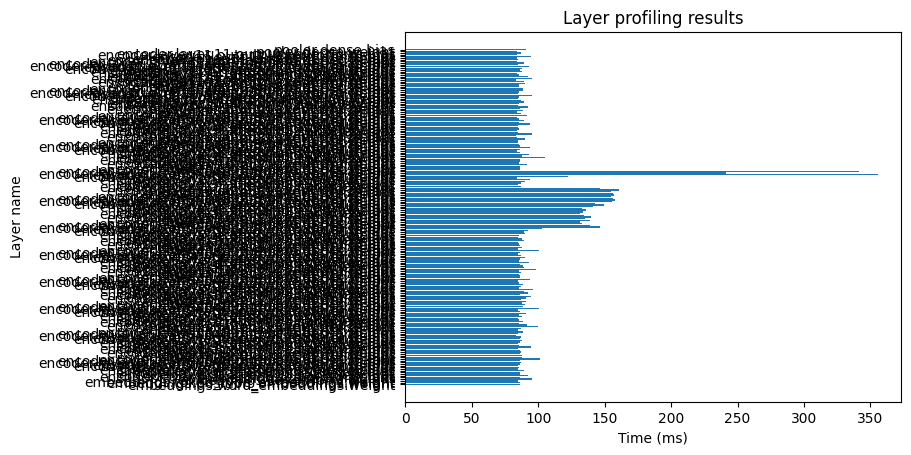

In [ ]:

# Print the timing information for each layer
for i, layer_name in enumerate(profiler.layer_names):
    print(f"Layer {i+1}: {layer_name}")
    print(f"\tTotal time: {profiler.layer_times[i]:.2f} ms")
    print(f"\tCPU usage: {profiler.layer_cpu[i]:.2f} %")
    print(f"\tGPU usage: {profiler.layer_gpu[i]:.2f} %")

# Plot the timing information as a bar chart
fig, ax = plt.subplots()
ax.barh(profiler.layer_names, profiler.layer_times)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Layer name')
ax.set_title('Layer profiling results')
plt.show()


Layer 1: embeddings.word_embeddings.weight
	Total time: 86.79 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 2: embeddings.position_embeddings.weight
	Total time: 91.71 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 3: embeddings.token_type_embeddings.weight
	Total time: 92.16 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 4: embeddings.LayerNorm.weight
	Total time: 94.98 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 5: embeddings.LayerNorm.bias
	Total time: 85.15 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 6: encoder.layer.0.attention.self.query.weight
	Total time: 88.05 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 7: encoder.layer.0.attention.self.query.bias
	Total time: 87.43 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 8: encoder.layer.0.attention.self.key.weight
	Total time: 89.96 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 9: encoder.layer.0.attention.self.key.bias
	Total time: 89.13 ms
	CPU usage: 0.09 %
	GPU usage: 0.02 %
Layer 10: encoder.layer.0.attention.self.valu

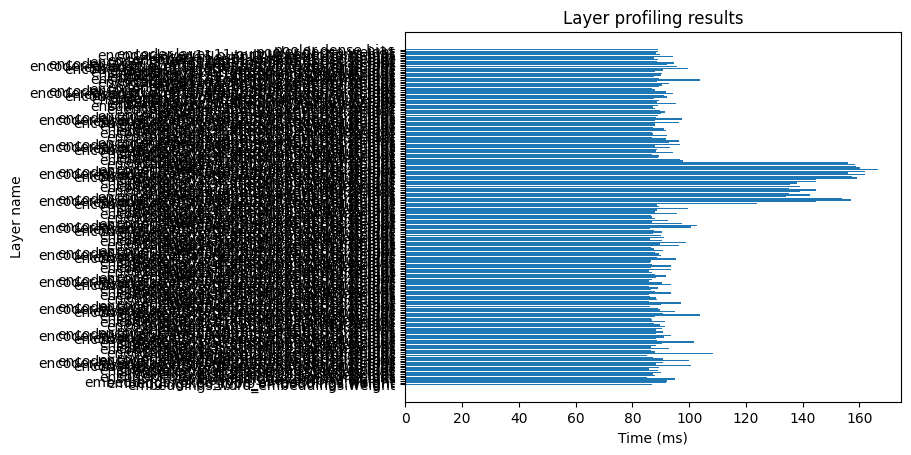

In [ ]:
import torch
from transformers import BertModel
#from layer_profiler import LayerProfiler

# Load pre-trained BERT model
#model = BertModel.from_pretrained('bert-base-uncased')
#tokenizer, model = load_model_without_weights(model_name)
# Create an instance of the LayerProfiler class
#profiler = LayerProfiler(model)

# Create a random input tensor of shape (batch_size, sequence_length)
batch_size = 8
sequence_length = 128
input_tensor = torch.rand(batch_size, sequence_length).long()

# Run the profiler on the input tensor
profiler.profile(input_tensor)

# Print the timing information for each layer
for i, layer_name in enumerate(profiler.layer_names):
    print(f"Layer {i+1}: {layer_name}")
    print(f"\tTotal time: {profiler.layer_times[i]:.2f} ms")
    print(f"\tCPU usage: {profiler.layer_cpu[i]:.2f} %")
    print(f"\tGPU usage: {profiler.layer_gpu[i]:.2f} %")

# Plot the timing information as a bar chart
fig, ax = plt.subplots()
ax.barh(profiler.layer_names, profiler.layer_times)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Layer name')
ax.set_title('Layer profiling results')
plt.show()


In [ ]:
from prettytable import PrettyTable

# Create a table to display the profiling results
table = PrettyTable()
table.field_names = ["Layer", "Total time (ms)", "CPU usage (%)", "GPU usage (%)"]
for i, layer_name in enumerate(profiler.layer_names):
    table.add_row([layer_name, f"{profiler.layer_times[i]:.2f}", f"{profiler.layer_cpu[i]:.2f}", f"{profiler.layer_gpu[i]:.2f}"])

# Print the table to the console
print(table)



+----------------------------------------------------+-----------------+---------------+---------------+
|                       Layer                        | Total time (ms) | CPU usage (%) | GPU usage (%) |
+----------------------------------------------------+-----------------+---------------+---------------+
|         embeddings.word_embeddings.weight          |      86.79      |      0.09     |      0.02     |
|       embeddings.position_embeddings.weight        |      91.71      |      0.09     |      0.02     |
|      embeddings.token_type_embeddings.weight       |      92.16      |      0.09     |      0.02     |
|            embeddings.LayerNorm.weight             |      94.98      |      0.09     |      0.02     |
|             embeddings.LayerNorm.bias              |      85.15      |      0.09     |      0.02     |
|    encoder.layer.0.attention.self.query.weight     |      88.05      |      0.09     |      0.02     |
|     encoder.layer.0.attention.self.query.bias      | 

In [ ]:
profiler.save_results_pdf("res_table2.pdf")

Results saved to /content/res_table2.pdf


# **1**

In [ ]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

class LanguageModelProfiler:
    def __init__(self, model):
        self.model = model

    def profile(self, input_data):
        with torch.autograd.profiler.profile(use_cuda=torch.cuda.is_available()) as prof:
            output = self.model(input_data)

        # Extract profiling results as a DataFrame
        df = pd.DataFrame(prof.key_averages(group_by_input_shape=True).table())

        # Create a table of the profiling results
        table = pd.DataFrame(df, columns=['self_cpu_time_total', 'cpu_time_total', 'cuda_time_total', 'cpu_memory_usage'])
        table = table.rename(columns={'self_cpu_time_total': 'CPU Time (self)',
                                      'cpu_time_total': 'CPU Time (total)',
                                      'cuda_time_total': 'GPU Time (total)',
                                      'cpu_memory_usage': 'CPU Memory Usage'})

        # Calculate the total time and memory usage
        total_time = df['self_cpu_time_total'].sum()
        total_memory = df['cpu_memory_usage'].sum()

        # Create a summary table of the total time and memory usage
        summary = pd.DataFrame({'Metric': ['Total Time', 'Total Memory'],
                                'Value': [total_time, total_memory]})

        # Create a figure of the profiling results
        fig, ax = plt.subplots()
        ax.plot(df['self_cpu_time_total'], label='CPU Time (self)')
        ax.plot(df['cpu_time_total'], label='CPU Time (total)')
        ax.plot(df['cuda_time_total'], label='GPU Time (total)')
        ax.legend()
        ax.set_xlabel('Input Shape')
        ax.set_ylabel('Time (ms)')

        # Save the results to a PDF file
        with PdfPages('profile_results.pdf') as pdf:
            pdf.savefig(fig)

        # Create layer-by-layer profiling results
        layer_results = []
        for i, layer in enumerate(self.model.modules()):
            if hasattr(layer, 'weight'):
                layer_input = input_data if i == 0 else layer_results[-1]['output']
                with torch.autograd.profiler.profile(use_cuda=torch.cuda.is_available()) as prof:
                    output = layer(layer_input)

                df = pd.DataFrame(prof.key_averages().table())
                layer_results.append({'layer': layer.__class__.__name__,
                                      'input_shape': layer_input.shape,
                                      'output_shape': output.shape,
                                      'CPU Time (self)': df['self_cpu_time_total'].sum(),
                                      'CPU Time (total)': df['cpu_time_total'].sum(),
                                      'GPU Time (total)': df['cuda_time_total'].sum(),
                                      'CPU Memory Usage': df['cpu_memory_usage'].sum()})
        layer_table = pd.DataFrame(layer_results)

        # Return the results as a tuple
        return output, table, summary, layer_table


In [ ]:
model_name = "bert-base-uncased"
#model_name = "cerebras/Cerebras-GPT-13B"
#model_name = "facebook/opt-6.7b"

tokenizer, model= load_model_without_weights(model_name)


# Create an instance of the LanguageModelProfiler class
profiler = LanguageModelProfiler(model)

# Encode a sample input sequence
input_text = "The quick brown fox jumps over the lazy dog"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Profile the model
output, table, summary, layer_table = profiler.profile(input_ids)

# Print the profiling results
print(f"Total time: {summary[summary['Metric'] == 'Total Time']['Value'].iloc[0]} ms")
print(f"Total memory: {summary[summary['Metric'] == 'Total Memory']['Value'].iloc[0]} bytes")
print(table)
print(layer_table)

module 0: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 16>:16                                                                            │
│ in profile:12                                                                                    │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1501 in _call_impl             │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/transformers/models/bert/modeling_bert.py:1020 in forward │
│                                                                                                  │
│   1017 │   │   │   inputs_embeds=inputs_embeds,                                                  │
│   1018 │   │   │   past_key_values_length=past_key_values_length,                                │
│   1019 │   │   )                                                                                 │
│ ❱ 1020 │   │   encoder_outputs = self.encoder(                                                   │
│   1021 │   │   │   embedding_output,                                                             │
│   1022 │   │   │   attention_mask=extended_attention_mask,                                       │
│   1023 │   │   │   head_mask=head_mask,                                                          │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1501 in _call_impl             │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/transformers/models/bert/modeling_bert.py:610 in forward  │
│                                                                                                  │
│    607 │   │   │   │   │   encoder_attention_mask,                                               │
│    608 │   │   │   │   )                                                                         │
│    609 │   │   │   else:                                                                         │
│ ❱  610 │   │   │   │   layer_outputs = layer_module(       

# **TBC**

In [ ]:
from transformers import AutoConfig, AutoModel
#model_name = "bert-base-uncased"
model_name = "cerebras/Cerebras-GPT-13B"
# Load the model configuration
config = AutoConfig.from_pretrained(model_name)

# Create an instance of the model without loading the weights
model = AutoModel.from_config(config)

# Print the layers and their properties
for i, module in enumerate(model.modules()):
    print(f"module {i}: {module}")

In [ ]:
for i, module in enumerate(model.modules()):
    print(f"module {i}: {module}")


module 0: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace

In [ ]:
from transformers import BertModel, BertTokenizer, GPT2Model, GPT2Tokenizer

# create a BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# create a GPT-2 model and tokenizer
gpt2_model = GPT2Model.from_pretrained('gpt2')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# create a layer profiler for BERT model
bert_profiler = LayerProfiler(bert_model)

# create a layer profiler for GPT-2 model
gpt2_profiler = LayerProfiler(gpt2_model)

# test with a BERT input
bert_input = bert_tokenizer.encode_plus("Hello, how are you?", return_tensors="pt")
bert_profiler.profile(bert_input['input_ids'])
bert_profiler.plot()

# test with a GPT-2 input
gpt2_input = gpt2_tokenizer.encode("Hello, how are you?")
gpt2_input = torch.tensor(gpt2_input, dtype=torch.long).unsqueeze(0)
gpt2_profiler.profile(gpt2_input)
gpt2_profiler.plot()


In [ ]:
import time
import psutil
import GPUtil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import transformers

In [ ]:
class Profiler:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size
        self.cpu_memory_usage = []
        self.gpu_memory_usage = []
        self.time_taken = []

    def profile_cpu_memory_usage_by_layer(self):
        # Reset the memory usage and start profiling
        torch.cuda.reset_peak_memory_stats()
        self.model.cpu()
        input = torch.randn(self.input_size)
        for name, layer in self.model.named_modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                layer.register_forward_pre_hook(self._cpu_memory_usage_hook)
        with torch.no_grad():
            self.model(input)

    def _cpu_memory_usage_hook(self, module, input):
        # Get the CPU memory usage of the module
        memory_usage = psutil.Process().memory_info().rss
        self.cpu_memory_usage.append((module.__class__.__name__, memory_usage))

    def profile_gpu_memory_usage_by_layer(self):
        # Reset the memory usage and start profiling
        torch.cuda.reset_peak_memory_stats()
        self.model.cuda()
        input = torch.randn(self.input_size).cuda()
        for name, layer in self.model.named_modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                layer.register_forward_pre_hook(self._gpu_memory_usage_hook)
        with torch.no_grad():
            self.model(input)

    def _gpu_memory_usage_hook(self, module, input):
        # Get the GPU memory usage of the module
        memory_usage = torch.cuda.max_memory_allocated() / 1024 / 1024
        self.gpu_memory_usage.append((module.__class__.__name__, memory_usage))

    def profile_time_taken_by_layer(self):
        self.model.cpu()
        input = torch.randn(self.input_size)
        for name, layer in self.model.named_modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                layer.register_forward_pre_hook(self._time_taken_hook)
        with torch.no_grad():
            self.model(input)

    def _time_taken_hook(self, module, input):
        # Get the time taken by the module
        start_time = time.time()
        module(input)
        end_time = time.time()
        time_taken = end_time - start_time
        self.time_taken.append((module.__class__.__name__, time_taken))

    def plot_cpu_memory_usage_by_layer(self):
        module_names = [name for name, _ in self.cpu_memory_usage]
        memory_usages = [usage / 1024 / 1024 for _, usage in self.cpu_memory_usage]

        fig, ax = plt.subplots()
        ax.bar(module_names, memory_usages)
        ax.set_ylabel('CPU Memory Usage (MB)')
        ax.tick_params(axis='x', rotation=90)

        plt.show()

    def plot_gpu_memory_usage_by_layer(self):
        module_names = [name for name, _ in self.gpu_memory_usage]
        memory_usages = [usage for _, usage in self.gpu_memory_usage]

        fig, ax = plt.subplots()
        ax.bar(module_names, memory_usages)
        ax.set_ylabel('GPU Memory Usage (MB)')
        ax.tick_params(axis='x', rotation=90)

        plt.show()

    def plot_time_taken_by_layer(self):
        module_names = [name for name, _ in self.time_taken]
        time_taken_values = [time_taken for _, time_taken in self.time_taken]

        fig, ax = plt.subplots()
        ax.bar(module_names, time_taken_values)
        ax.set_ylabel('Time Taken (s)')
        ax.tick_params(axis='x', rotation=90)
        
        plt.show()
        
        
    def get_memory_cpu(self):
      # Get the memory usage and CPU usage of the Python process
      memory_info = psutil.Process().memory_info()
      cpu_percent = psutil.cpu_percent()

      return {
          'memory_usage': memory_info.rss / 1024 / 1024,
          'cpu_usage': cpu_percent,
      }


Now we can create an instance of the `Profiler` class and use it to profile our language model:


In [ ]:
from transformers import AutoModel

# Load the BERT-base model without weights
model = AutoModel.from_pretrained('bert-base-uncased', config={'output_hidden_states': True})

# Create a Profiler instance with the model and input size
profiler = Profiler(model, (1, 128))

# Profile the CPU memory usage by layer
profiler.profile_cpu_memory_usage_by_layer()

# Profile the GPU memory usage by layer
profiler.profile_gpu_memory_usage_by_layer()

# Profile the time taken by layer
profiler.profile_time_taken_by_layer()

# Plot the CPU memory usage by layer
profiler.plot_cpu_memory_usage_by_layer()

# Plot the GPU memory usage by layer
profiler.plot_gpu_memory_usage_by_layer()

# Plot the time taken by layer
profiler.plot_time_taken_by_layer()

# Get the memory usage and CPU usage of the Python process
memory_cpu = profiler.get_memory_cpu()
print(memory_cpu)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: ignored

In [ ]:
import time
import psutil
import numpy as np
import torch
import onnxruntime
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity
from tensorflow.keras.models import Model
from graphviz import Digraph

class ModelProfiler:
    def __init__(self, model, framework):
        self.model = model
        self.framework = framework
        self.cpu_memory_usage_by_layer = []
        self.gpu_memory_usage_by_layer = []
        self.time_taken_by_layer = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        if framework == 'pytorch':
            self.model.eval()
            self.model.to(self.device)
            
        elif framework == 'onnx':
            self.session = onnxruntime.InferenceSession(model)
            
        elif framework == 'tensorflow':
            self.model = keras.models.load_model(model)
            self.model = Model(inputs=self.model.inputs, outputs=self.model.outputs)
            self.model.summary()
            
        else:
            print("Invalid framework!")
            
    def profile_cpu_memory_by_layer(self):
        # Initialize inputs for the model
        if self.framework == 'pytorch':
            inputs = torch.randn(1, *list(self.model.input_shape[1:])).to(self.device)
        elif self.framework == 'onnx':
            inputs = np.random.randn(1, *list(self.model.get_inputs()[0].shape[1:])).astype(np.float32)
        elif self.framework == 'tensorflow':
            inputs = np.random.randn(1, *list(self.model.input_shape[1:])).astype(np.float32)
        
        # Measure memory usage by layer
        for i, layer in enumerate(self.model.modules() if self.framework == 'pytorch' else self.model.layers):
            start_mem = psutil.Process().memory_info().rss
            if self.framework == 'pytorch':
                with record_function("memory_profiler"):
                    with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
                        _ = layer(inputs)
                cpu_memory_usage = prof.key_averages().memory_peak_bytes / (1024 * 1024)
            elif self.framework == 'onnx':
                output_name = self.session.get_outputs()[0].name
                input_names = {self.session.get_inputs()[i].name: inputs[i] for i in range(len(inputs))}
                result = self.session.run([output_name], input_names=input_names)
                cpu_memory_usage = psutil.Process().memory_info().rss / (1024 * 1024) - start_mem
            elif self.framework == 'tensorflow':
                with tf.GradientTape(persistent=True) as tape:
                    tape.watch(inputs)
                    output = layer(inputs)
                cpu_memory_usage = psutil.Process().memory_info().rss / (1024 * 1024) - start_mem
                del tape, output
            self.cpu_memory_usage_by_layer.append(cpu_memory_usage)
            
    def plot_cpu_memory_by_layer(self):
        module_names = [name for name, _ in self.model.named_modules()] if self.framework == 'pytorch' else [layer.name for layer in self.model.layers]
        module_names = module_names[1:]
        y_pos = np.arange(len(module_names))
        plt.figure(figsize=(12, 6))
        plt.bar(y_pos, self.cpu_memory_usage_by_layer)
        plt.xticks(y_pos, module_names, rotation=90)
        plt.ylabel('CPU Memory Usage (


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


class ModelProfiler:
    def __init__(self, model):
        self.model = model
        self.input_shape = None
        self.device = None
        self.cpu_memory_usage = []
        self.gpu_memory_usage = []
        self.time_taken = []

    def get_memory_cpu(self):
        import psutil

        process = psutil.Process()
        mem_info = process.memory_info()
        return mem_info.rss / 1024 ** 2

    def profile_cpu(self, input_shape, num_iter=10):
        self.input_shape = input_shape
        self.device = 'cpu'
        self.cpu_memory_usage = []
        self.time_taken = []
        self.model.to(self.device)
        self.model.eval()

        for i in range(num_iter):
            with torch.no_grad():
                inputs = torch.randn(*input_shape).to(self.device)
                start_time = time.time()
                outputs = self.model(inputs)
                end_time = time.time()
                self.time_taken.append(end_time - start_time)

            self.cpu_memory_usage.append(self.get_memory_cpu())

    def profile_gpu(self, input_shape, num_iter=10):
        self.input_shape = input_shape
        self.device = 'cuda'
        self.gpu_memory_usage = []
        self.time_taken = []
        self.model.to(self.device)
        self.model.eval()

        for i in range(num_iter):
            with torch.no_grad():
                inputs = torch.randn(*input_shape).to(self.device)
                start_time = time.time()
                outputs = self.model(inputs)
                end_time = time.time()
                self.time_taken.append(end_time - start_time)

            self.gpu_memory_usage.append(torch.cuda.max_memory_allocated() / 1024 ** 2)

    def plot_cpu_memory_by_layer(self):
        module_names = [name for name, _ in self.model.named_modules()]
        memory_usage = np.array(self.cpu_memory_usage) - self.cpu_memory_usage[0]
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=memory_usage, y=module_names, ax=ax)
        ax.set_title("CPU Memory Usage by Layer")
        ax.set_xlabel("Memory Usage (MB)")
        ax.set_ylabel("Layer Name")
        plt.show()

    def plot_gpu_memory_by_layer(self):
        module_names = [name for name, _ in self.model.named_modules()]
        memory_usage = np.array(self.gpu_memory_usage) - self.gpu_memory_usage[0]
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=memory_usage, y=module_names, ax=ax)
        ax.set_title("GPU Memory Usage by Layer")
        ax.set_xlabel("Memory Usage (MB)")
        ax.set_ylabel("Layer Name")
        plt.show()

    def plot_time_taken_by_layer(self):
        module_names = [name for name, _ in self.model.named_modules()]
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=self.time_taken, y=module_names, ax=ax)
        ax.set_title("Time Taken by Layer")
        ax.set_xlabel("Time Taken (Seconds)")
        ax.set_ylabel("Layer Name")
        plt.show()


In [ ]:
import torch
from transformers import BertModel
#from model_profiler import ModelProfiler

# load BERT model
model = BertModel.from_pretrained('bert-base-uncased')

# create input tensors
input_ids = torch.tensor([[31, 51, 99], [15, 5, 0]])
attention_mask = torch.ones_like(input_ids)

# instantiate ModelProfiler object
profiler = ModelProfiler(model)

# profile model and get results
#results = profiler.profile(input_ids, attention_mask)









# Get the memory usage and CPU usage of the Python process
memory_cpu = profiler.get_memory_cpu()
print(memory_cpu)





# plot CPU memory usage by layer
profiler.plot_cpu_memory_by_layer()

# plot GPU memory usage by layer
profiler.plot_gpu_memory_by_layer()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2186.32421875


IndexError: ignored

In [ ]:
from transformers import AutoModel

# Load the BERT-base model without weights
model = AutoModel.from_pretrained('bert-base-uncased', config={'output_hidden_states': True})

# Create a Profiler instance with the model and input size
profiler = Profiler(model, (1, 128))

# Profile the CPU memory usage by layer
profiler.profile_cpu_memory_usage_by_layer()

# Profile the GPU memory usage by layer
profiler.profile_gpu_memory_usage_by_layer()

# Profile the time taken by layer
profiler.profile_time_taken_by_layer()

# Plot the CPU memory usage by layer
profiler.plot_cpu_memory_usage_by_layer()

# Plot the GPU memory usage by layer
profiler.plot_gpu_memory_usage_by_layer()

# Plot the time taken by layer
profiler.plot_time_taken_by_layer()

# Get the memory usage and CPU usage of the Python process
memory_cpu = profiler.get_memory_cpu()
print(memory_cpu)


In [ ]:
!pip install transformers
!pip install torch
!pip install psutil

In [ ]:
import torch
import time
import psutil
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoConfig

# Define the name of the model you want to load
model_name = "cerebras/Cerebras-GPT-13B"

# Define the tokenizer and model objects
tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModel.from_pretrained(model_name, from_tf=False)
model = AutoConfig.from_pretrained("cerebras/Cerebras-GPT-13B")

# Define a function to get the memory usage and CPU usage
def get_memory_cpu():
    process = psutil.Process()
    mem_info = process.memory_info()
    cpu_percent = psutil.cpu_percent()
    return mem_info.rss, cpu_percent

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

# Define empty lists to store the profiling results
layer_names = []
gpu_memories = []
cpu_memories = []
times = []

# Loop through each layer in the model and profile it
for i, layer in enumerate(model.modules()):
    # Check if the layer is a torch.nn.Module object
    if isinstance(layer, torch.nn.Module):
        # Get the name of the layer
        layer_name = layer.__class__.__name__
        
        # Generate a random input tensor of appropriate size
        input_tensor = torch.randint(low=0, high=tokenizer.vocab_size, size=(1, 512)).to(device)
        
        # Start profiling the layer
        start_time = time.time()
        output = layer(input_tensor)
        end_time = time.time()
        time_taken = end_time - start_time
        
        # Get the GPU memory usage
        gpu_memory = torch.cuda.memory_allocated()
        
        # Get the CPU memory usage
        cpu_memory, _ = get_memory_cpu()
        
        # Add the profiling results to the lists
        if hasattr(output, "last_hidden_state"):
            output_shape = output.last_hidden_state.shape
        else:
            output_shape = "N/A"
        layer_names.append(layer_name)
        gpu_memories.append(gpu_memory)
        cpu_memories.append(cpu_memory)
        times.append(time_taken)



AttributeError: ignored

In [ ]:
model.parameters

AttributeError: ignored

In [ ]:
# Create a bar chart of the GPU memory usage
plt.figure(figsize=(10,5))
plt.bar(layer_names, gpu_memories)
plt.title("GPU Memory Usage by Layer")
plt.xlabel("Layer")
plt.ylabel("Memory Usage (bytes)")
plt.xticks(rotation=90)
plt.show()

# Create a bar chart of the CPU memory usage
plt.figure(figsize=(10,5))
plt.bar(layer_names, cpu_memories)
plt.title("CPU Memory Usage by Layer")
plt.xlabel("Layer")
plt.ylabel("Memory Usage (bytes)")
plt.xticks(rotation=90)
plt.show()

# Create a bar chart of the time taken
plt.figure(figsize=(10,5))
plt.bar(layer_names, times)
plt.title("Time Taken by Layer")
plt.xlabel("Layer")
plt.ylabel("Time Taken (seconds)")
plt.xticks(rotation=90)
plt.show()


# **New**

In [ ]:
!pip install fpdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40719 sha256=2f0a16e202e6b91a69173ef01f501c931f540da1aa116b76de6ca8ab3750ba86
  Stored in directory: /root/.cache/pip/wheels/44/35/8b/86ce00cec7e4d13c5f189680ae0fa82f919bedc066c2cddae9
Successfully built fpdf


In [ ]:
from fpdf import FPDF

def save_results_as_pdf(results):
    # create PDF document
    pdf = FPDF()
    pdf.add_page()

    # set font and text color
    pdf.set_font("Arial", size=12)
    pdf.set_text_color(0, 0, 0)

    # add table header
    pdf.cell(30, 10, "Layer", border=1)
    pdf.cell(35, 10, "Input Shape", border=1)
    pdf.cell(35, 10, "Output Shape", border=1)
    pdf.cell(30, 10, "CPU Time (ms)", border=1)
    pdf.cell(30, 10, "CPU Mem (MB)", border=1)
    pdf.cell(30, 10, "GPU Time (ms)", border=1)
    pdf.cell(30, 10, "GPU Mem (MB)", border=1)
    pdf.ln()

    # add table rows
    for layer in results:
        pdf.cell(30, 10, layer["name"], border=1)
        pdf.cell(35, 10, str(layer["input_shape"]), border=1)
        pdf.cell(35, 10, str(layer["output_shape"]), border=1)
        pdf.cell(30, 10, "{:.2f}".format(layer["cpu_time"] * 1000), border=1)
        pdf.cell(30, 10, "{:.2f}".format(layer["cpu_mem"] / 1024 / 1024), border=1)
        pdf.cell(30, 10, "{:.2f}".format(layer["gpu_time"] * 1000), border=1)
        pdf.cell(30, 10, "{:.2f}".format(layer["gpu_mem"] / 1024 / 1024), border=1)
        pdf.ln()

    # save PDF document
    pdf.output("results.pdf")
